In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Kuliah/Tugas_Akhir

/content/drive/MyDrive/Kuliah/Tugas_Akhir


In [ ]:
import numpy as np
import tensorflow as tf
import keras
import os
import cv2
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
np.random.seed(3)

In [ ]:
timesteps = 20
n_labels = 4
batch_size = 16 #dicoba batch size 32 sama 64
validation_ratio = 0.2 #dicoba validation rate 20%
num_epochs = 50
img_col = 224
img_row = 224
img_channel = 3
# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["Membuka Kertas Contekan", "Membuka Smartphone", "Bertukar kertas jawaban", "Melihat Kertas Jawaban Teman"]

In [ ]:
# 1. Creating Datasets
# define temporary empty list for load
data = []
label = []
Totalnb = 0

# Load Dataset
for i in range(n_labels):
    nb = 0
    # Counting datasets in each labels
    for root, dirs, files in os.walk('Progress/DataLatihBaru/' + str(i+1)): # set directory
        for name in dirs:
            nb = nb + 1
    print(i,"Label number of Dataset is:",nb)
    Totalnb = Totalnb + nb
    # by Counting size, cross subfolder and read image data, resize image, and append list 
    for j in range(nb):
        temp = []
        for k in range(timesteps):
            # name = 'NormalizedCascaded/' + str(i+1) + '/' + str(j+1) + '/' + str(k+1) + '.jpg'
            name = 'Progress/DataLatihBaru/' + str(i+1) + '/' + str(j+1) + '/' + 'a (' + str(k+1) + ')' + '.jpg'
            img = cv2.imread(name)
            res = cv2.resize(img, dsize=(img_col, img_row), interpolation=cv2.INTER_CUBIC)
            temp.append(res)
        label.append(i)        
        data.append(temp)
print("Total Number of Data is",Totalnb)

# Convert List to numpy array, for Keras use
Train_label = np.eye(n_labels)[label] # One-hot encoding by np array function
Train_data = np.array(data)
print("Dataset shape is",Train_data.shape, "(size, timestep, column, row, channel)")
print("Label shape is",Train_label.shape,"(size, label onehot vector)")

0 Label number of Dataset is: 106
1 Label number of Dataset is: 104
2 Label number of Dataset is: 34
3 Label number of Dataset is: 93
Total Number of Data is 337
Dataset shape is (337, 20, 224, 224, 3) (size, timestep, column, row, channel)
Label shape is (337, 4) (size, label onehot vector)


In [ ]:
# shuffling dataset for input fit function
# if don`t, can`t train model entirely
x = np.arange(Train_label.shape[0])
np.random.shuffle(x)
# same order shuffle is needed
Train_label = Train_label[x]
Train_data = Train_data[x]

train_size = 0.9
X_train=Train_data[:int(Totalnb * 0.9),:]
Y_train=Train_label[:int(Totalnb * 0.9)]
X_test=Train_data[int(Totalnb * 0.1):,:]
Y_test=Train_label[int(Totalnb * 0.1):]

In [ ]:
# 2. Buliding a Model
# declare input layer for CNN+LSTM architecture
video = Input(shape=(timesteps,img_col,img_row,img_channel))
STEPS_PER_EPOCH = 120
#AlexNet Layer
model = tf.keras.models.Sequential([
    # 1st conv
  tf.keras.layers.Conv2D(96, (11,11),strides=(4,4), activation='relu', input_shape=(img_col, img_row, img_channel)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2,2)),
    # 2nd conv
  tf.keras.layers.Conv2D(256, (5,5),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2,2)),
     # 3rd conv
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
    # 4th conv
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
    # 5th Conv
  tf.keras.layers.Conv2D(256, (3,3), strides=(1, 1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2,2)),
])
# model.trainable = False
# FC Dense Layer
x = model.output
x = Flatten()(x)
fcl1 = Dense(4096)(x)
fcl2 = Dense(4096)(fcl1)
cnn_out = Dense(1000)(fcl2)
# Construct CNN model 
Lstm_inp = Model(model.input, cnn_out)
# Distribute CNN output by timesteps 
encoded_frames = TimeDistributed(Lstm_inp)(video)
# Contruct LSTM model 
encoded_sequence = LSTM(256)(encoded_frames)
hidden_Drop = Dropout(0.2)(encoded_sequence)
hidden_layer = Dense(128)(hidden_Drop)
outputs = Dense(n_labels, activation="softmax")(hidden_layer)
# Contruct CNN+LSTM model 
model = Model([video], outputs)
# 3. Setting up the Model Learning Process
# Model Compile 
opt = SGD(lr=0.001)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy'])
model.summary()
# 4. Training the Model
hist = model.fit(X_train, Y_train, batch_size=batch_size, validation_split=validation_ratio, shuffle=True, epochs=num_epochs)



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 224, 224, 3)  0         
                             ]                                   
                                                                 
 time_distributed (TimeDistr  (None, 20, 128)          3568064   
 ibuted)                                                         
                                                                 
 lstm (LSTM)                 (None, 256)               394240    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 4)                 516 

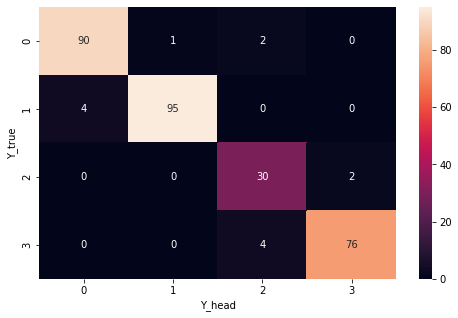

              precision    recall  f1-score   support

           0       0.96      0.97      0.96        93
           1       0.99      0.96      0.97        99
           2       0.83      0.94      0.88        32
           3       0.97      0.95      0.96        80

    accuracy                           0.96       304
   macro avg       0.94      0.95      0.95       304
weighted avg       0.96      0.96      0.96       304



In [ ]:
Y_pred2 = model.predict(X_test)
y_pred= np.argmax(Y_pred2, axis=1) # prediksi
Y_test = np.argmax(Y_test, axis=1)
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, y_pred) 
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(Y_test, y_pred), annot=True, fmt=".0f", ax=ax)
plt.xlabel("Y_head")
plt.ylabel("Y_true")
plt.show()
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred))

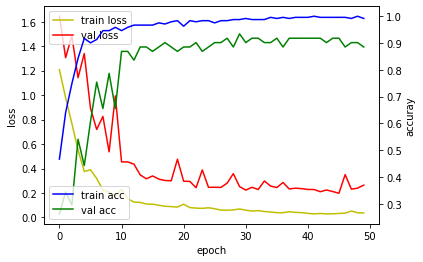

In [ ]:
# 5. Confirm the Learning Process
%matplotlib inline 
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.plot(hist.history['loss'], 'y', label='train loss')  
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')  
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()

In [ ]:
# 6. Using the Model
model.save('testNilaiLayerBaru1E-3_16B.h5')

In [ ]:

# # 7. Using the Model on Other Dataset
# # Load keras package needed
# import numpy as np
# import tensorflow as tf
# import keras
# import numpy as np
# from numpy import argmax
# import os
# import cv2
# from keras.utils import np_utils
# from keras.models import Sequential, Model, load_model
# from keras.preprocessing import image as image_utils

In [ ]:
# model = load_model('CCTV_10Frame_SGD_Model_1e4_b16_regul2_Dropout.h5')

In [ ]:
# data = []
# label = []
# n_labels = 5
# Totalnb = 0
# data_nb = [0,0,0,0,0]

# # Load Dataset
# for i in range(5):
#     nb = 0
#     for root, dirs, files in os.walk('Normalized CascadeTest/' + str(i+1)):  # set directory
#         for name in dirs:
#             nb = nb + 1
#     print(i,"Label number of Dataset is:",nb)
#     Totalnb = Totalnb + nb
#     data_nb[i] = data_nb[i] + nb
#     for j in range(nb-1):
#         temp = []
#         for k in range(10):
#             name = 'Normalized CascadeTest/' + str(i+1) + '/' + str(j+1) + '/' + 'a (' + str(k+1) + ')' + '.jpg'
#             img = cv2.imread(name)
#             res = cv2.resize(img, dsize=(img_col, img_row), interpolation=cv2.INTER_CUBIC)
#             temp.append(res)
#         label.append(i)        
#         data.append(temp)
# print("Total Number of Data is",Totalnb)
# Train_label = np.eye(n_labels)[label]
# Train_data = np.array(data)

In [ ]:
# x = np.arange(Train_label.shape[0])
# np.random.shuffle(x)
# Train_label = Train_label[x]
# Train_data = Train_data[x]

In [ ]:
# npp = 0
# n0 = 0
# n1 = 0
# n2 = 0
# n3 = 0
# n4 = 0


# for i in range(Train_label.shape[0]):
#     # Test model by each image timesteps
#     Train_dataOne = Train_data[i]
#     Train_dataOne = np.expand_dims(Train_dataOne, axis=0)
#     # Use model class probability
#     Y_data = model.predict(Train_dataOne, batch_size = 1)
#     # Use model class
#     y_classes = Y_data.argmax(axis=-1)
#     # print result predicted class / model input label ( One_hot Code )
#     print(y_classes, Train_label[i])
#     if (Train_label[i][y_classes] == 1):
#         npp = npp + 1
#         if (y_classes == 0):
#             n0 = n0 + 1
#         if (y_classes == 1):
#             n1 = n1 + 1
#         if (y_classes == 2):
#             n2 = n2 + 1
#         if (y_classes == 3):
#             n3 = n3 + 1
#         if (y_classes == 4):
#             n4 = n4 + 1
#         if (y_classes == 5):
#             n5 = n5 + 1
#         if (y_classes == 6):
#             n6 = n6 + 1
#         if (y_classes == 7):
#             n7 = n7 + 1

# # print Total Result
# print("Number of correct answers is", npp,"into", 96, "Test Acc is",npp/96)
# print("Number of correct answers for each classes is ",n0,n1,n2,n3,n4)
# print("Accuary of each classes is ",n0/data_nb[0],n1/data_nb[1],n2/data_nb[2],n3/data_nb[3],n4/data_nb[4])

In [ ]:
# #Loading the saved model
# new_model = tf.keras.models.load_model("CCTV_10Frame_Model.h5")
# new_model.summary()
# loss, acc = new_model.evaluate(Train_data)
# print("accuracy:{:.2f}%".format(acc*100))